In [3]:
%matplotlib inline
import ROOT

In [1]:
from root_numpy import tree2array, root2array, rec2array
import numpy as np


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.neural_network import MLPClassifier

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import pandas.core.common as com
from pandas.core.index import Index
from pandas.tools import plotting


Welcome to JupyROOT 6.12/04


In [81]:
#convert skimmed MC trees to numpy arrays
MCdir = '/var/pcfst/r01/lhcb/delaney/Analysis/LHCbAnalysis/Bc2Dmunu/sub_jobs_MC_SB/'
BkgMC='MCBu2DMuNu.root'
SigMC='MCBc2DMuNu.root'

bkgFile = ROOT.TFile(MCdir+BkgMC)
sigFile = ROOT.TFile(MCdir+SigMC)

bkgTree = bkgFile.Get('AnalysisTree')
sigTree = sigFile.Get('AnalysisTree')


#eventually load one tree and include itype selection
Sevtmax=-1
Bevtmax=-1


#should rename with string manipulation
#'B_plus_MCORRERR/B_plus_MCORR' bdt output correlated with MCORR
branches=['TMath::Log(B_plus_PT)', 
'TMath::Log(B_plus_IPCHI2_OWNPV)', 'TMath::ACos(B_plus_DIRA_OWNPV)', 'B_plus_LTIME', 'TMath::Log(D0_PT)','TMath::Log(D0_IPCHI2_OWNPV)',
'TMath::Log(Mu_plus_PT)', 'TMath::Log(Mu_plus_MIPCHI2PV)'] 

sigArray = tree2array(sigTree, branches, selection='B_plus_LTIME>0', start=0, stop=Sevtmax) 
sig=rec2array(sigArray)

bkgArray = tree2array(bkgTree, branches, selection='B_plus_LTIME>0', start=0, stop=Bevtmax) 
bkg=rec2array(bkgArray)


print '\n--- Selected %i entries to read in from MC ---\n'%(len(sig)+len(bkg))
print '--- %s signal events and %s bkg events ---\n'%(len(sig),len(bkg))


#scikit learn requires 2D array (n_samples, n_features)
X = np.concatenate((sig, bkg))
y = np.concatenate((np.ones(sig.shape[0]),
                    np.zeros(bkg.shape[0])))

print 'X', X.shape
print 'Dev', X_dev.shape, y_dev.shape
print 'Eval', X_eval.shape, y_eval.shape
print 'Train',X_train.shape, y_train.shape
print 'Test',X_test.shape, y_test.shape


--- Selected 856106 entries to read in from MC ---

--- 16279 signal events and 839827 bkg events ---

X (856106, 8)
Dev (19195, 8) (19195,)
Eval (12798, 8) (12798,)
Train (308197, 8) (308197,)
Test (205466, 8) (205466,)


In [82]:
X_dev,X_eval, y_dev,y_eval = train_test_split(X, y, test_size=.4, random_state=23)
#X_train,X_test, y_train,y_test = train_test_split(X_dev, y_dev, test_size=0.4, random_state=199)

In [26]:
results = {}

def optimize_performance(clf, pars):
    
    def grid_search(clf, pars):
        
        grid = GridSearchCV(clf, 
                            param_grid=pars, 
                            n_jobs=-1, 
                            scoring='roc_auc',
                            cv=3)
        grid.fit(X_dev, y_dev)
        return grid

    grid=grid_search(clf, pars)
     
    print "Best parameter set found on development set:"
    print
    print grid.best_estimator_
    print
    print "Grid scores on a subset of the development set:"
    print
    for params, mean_score, scores in grid.grid_scores_:
        print "%0.4f (+/-%0.04f) for %r"%(mean_score, scores.std(), params)
    print
    print "With the model trained on the full development set:"

    y_true, y_pred = y_dev, grid.decision_function(X_dev)
    print "  It scores %0.4f on the full development set"%roc_auc_score(y_true, y_pred)
    y_true, y_pred = y_eval, grid.decision_function(X_eval)
    print "  It scores %0.4f on the full evaluation set"%roc_auc_score(y_true, y_pred)
  

    #return grid.best_score_, grid.best_estimator_
    results[grid.best_estimator_] = grid.best_score_
    #clf = sorted(results.iteritems(), key=lambda (k,v): (v,k), reverse=True)[0][0]
    
    return grid.best_estimator_


In [27]:
gbt = GradientBoostingClassifier() #defaults
gbt_param_grid = {"n_estimators": [50,200,400,1000],
                  "max_depth": [1, 3, 8],
                  'learning_rate': [0.1, 0.2, 1.]}

gbt=optimize_performance(gbt, gbt_param_grid)

Best parameter set found on development set:

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=8,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=1000, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

Grid scores on a subset of the development set:

0.8164 (+/-0.0039) for {'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 1}
0.8293 (+/-0.0025) for {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 1}
0.8357 (+/-0.0021) for {'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 1}
0.8457 (+/-0.0017) for {'n_estimators': 1000, 'learning_rate': 0.1, 'max_depth': 1}
0.8411 (+/-0.0022) for {'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 3}
0.8707 (+/-0.0008) for {'n_estimators': 200, 'learning_rat

/cvmfs/sft.cern.ch/lcg/views/LCG_92/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


  It scores 1.0000 on the full development set
  It scores 0.9379 on the full evaluation set


In [37]:
gbt = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=8,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=1000, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)
gbt.fit(X_dev, y_dev)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=8,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=1000, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [28]:
gbty_predicted = gbt.predict(X_eval)
print classification_report(y_eval, gbty_predicted,
                                    target_names=["background", "signal"])
print "Area under ROC curve: %.4f"%(roc_auc_score(y_eval, gbt.decision_function(X_eval)))

             precision    recall  f1-score   support

 background       0.89      0.81      0.85      6442
     signal       0.82      0.90      0.86      6356

avg / total       0.85      0.85      0.85     12798

Area under ROC curve: 0.9379


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=8,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=1000, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)


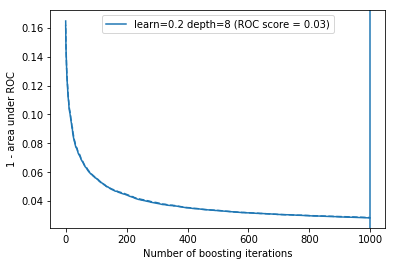

In [85]:
#check for overtraining, take pars from K-CV
print gbt

clfs=[]

depth=8
learn=.2


clf=gbt
clfs.append(clf)

def validation_curve(clfs, train, test):
    X_eval, y_eval = test
    X_dev, y_dev = train
    
    for n,clf in enumerate(clfs):
        test_score = np.empty(len(clf.estimators_))
        train_score = np.empty(len(clf.estimators_))

        for i, pred in enumerate(clf.staged_decision_function(X_eval)):
            test_score[i] = 1-roc_auc_score(y_eval, pred)

        for i, pred in enumerate(clf.staged_decision_function(X_dev)):
            train_score[i] = 1-roc_auc_score(y_dev, pred)

        best_iter = np.argmin(test_score)
        learn = clf.get_params()['learning_rate']
        depth = clf.get_params()['max_depth']
        test_line = plt.plot(test_score,
                             label='learn=%.1f depth=%i (ROC score = %.2f)'%(learn,depth,
                                                                 test_score[best_iter]))

        colour = test_line[-1].get_color()
        plt.plot(train_score, '--', color=colour)
        
        plt.xlabel("Number of boosting iterations")
        plt.ylabel("1 - area under ROC")
        plt.axvline(x=best_iter, color=colour)
        plt.savefig('allrunlearn.pdf')
        
    plt.legend(loc='best')
    plt.show()

validation_curve(clfs,
            (X_dev,y_dev),
            (X_eval,y_eval))

(19195, 8) (19195,)
(12798, 8) (12798,)


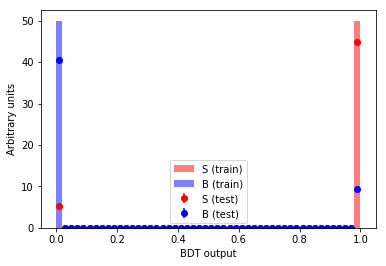

In [69]:


def compare_train_test(clf, X_dev, y_dev, X_eval, y_eval, bins=50):
    decisions = []
    for X,y in ((X_dev, y_dev), (X_eval, y_eval)):
        print X.shape, y.shape
        d1 = clf.predict(X[y==1]).ravel()
        d2 = clf.predict(X[y==0]).ravel()
        decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
    
    plt.hist(decisions[0],
             color='r', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', normed=True,
             label='S (train)')
    plt.hist(decisions[1],
             color='b', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', normed=True,
             label='B (train)')

    hist, bins = np.histogram(decisions[2],
                              bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')
    
    hist, bins = np.histogram(decisions[3],
                              bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')

    plt.xlabel("BDT output")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')
    plt.savefig('randomPLEASE_gbtoutput.pdf')

compare_train_test(gbt, X_dev, y_dev, X_eval, y_eval)

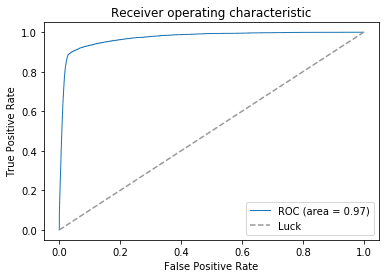

In [84]:
from sklearn.metrics import roc_curve, auc

decisions = gbt.decision_function(X_eval)
# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_eval, decisions)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)'%(roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
plt.savefig('gbt_roc.pdf')

In [46]:
y_predicted = gbt.predict(X_eval)
print classification_report(y_eval, y_predicted,
                            target_names=["background", "signal"])
print "Area under ROC curve: %.4f"%(roc_auc_score(y_eval,
                                                  gbt.decision_function(X_eval)))

             precision    recall  f1-score   support

 background       1.00      0.83      0.90    335862
     signal       0.10      0.96      0.18      6581

avg / total       0.98      0.83      0.89    342443

Area under ROC curve: 0.9717


In [82]:
dt = DecisionTreeClassifier(max_depth=3) #if max_depth=None, nodes expanded until leaves are pure
bdt = AdaBoostClassifier(base_estimator=dt)
bdt_param_grid ={'n_estimators': [10, 30, 50,100, 200, 500, 800, 1000],
                 'learning_rate': [.1, .2, .5],
                 'algorithm': ["SAMME", "SAMME.R"]}

bdt = optimize_performance(bdt, bdt_param_grid)


KeyboardInterrupt: 

In [ ]:
def compare_train_test(clf, X_dev, y_dev, X_eval, y_eval, bins=50):
    decisions = []
    for X,y in ((X_dev, y_dev), (X_eval, y_eval)):
        d1 = clf.decision_function(X[y>0.5]).ravel()
        d2 = clf.decision_function(X[y<0.5]).ravel()
        decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
    
    plt.hist(decisions[0],
             color='r', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', normed=True,
             label='S (train)')
    plt.hist(decisions[1],
             color='b', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', normed=True,
             label='B (train)')

    hist, bins = np.histogram(decisions[2],
                              bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')
    
    hist, bins = np.histogram(decisions[3],
                              bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')

    plt.xlabel("BDT output")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')
    plt.savefig('futurerun_gbt_FULLSAMPLE_novalidation_bdtoutput.pdf')

compare_train_test(bdt, X_dev, y_dev, X_eval, y_eval)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 10 but corresponding boolean dimension is 31993